### Description

Here should be exploratorial analysis - different plots, attempts to understand data, etc.

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import igraph

In [2]:
os.listdir("../data")

['.DS_Store',
 'description.txt',
 'input_wagon.xlsx',
 'output_wagon.xlsx',
 'wagon.zip']

In [3]:
df = pd.read_excel("../data/input_wagon.xlsx", sheet_name=None)

In [4]:
list(df)

['Orders_07',
 'Orders_08',
 'WagonModelCompatibility',
 'sources',
 'standplaces',
 'Metrics']

# EDA таблиц

## 1. Orders_07

Что сделать/выяснить:
- [ ] посмотреть ID заказа - есть ли закономерности. Часть номеров короткие - с чем это может быть связано?
- [ ] тариф: как интерпретировать набор цифр с разделителями?

In [5]:
def read_table(table_name="Orders_07"):
    table_df = df[table_name]
    columns = table_df.columns
    column_names = table_df.iloc[0].values
    table_df = table_df.loc[1:]
    table_df.columns = column_names
    for c, d in zip(columns, column_names):
        print(d, "-", c)
    return table_df

orders7 = read_table("Orders_07")

OrderNum - ID заказа
Start - Вершина старта
Finish - Вершина финиша
StartDate - Дата старта относительно дня запуска расчета, сутки
Dur - Время выполнения заказа (движения по арке+погрузка и разгрузка, сутки)
MinUnit - Минимальный обьем заказа, вагоны
MaxUnit - Максимальный обьем заказа, вагоны
Tariff - Тариф в зависимотси от отклонения от даты старта ( за вагон), рубли
NeedWagonModel - Запрошенная категория вагона
ShortagePenalty - Категория приоритетности заказа (убывание от 1 до 4)


In [18]:
orders7.to_csv("../data/orders7.csv.gz")

In [6]:
orders7.head()

,OrderNum,Start,Finish,StartDate,Dur,MinUnit,MaxUnit,Tariff,NeedWagonModel,ShortagePenalty
1,302201_812941937003_0707,932103,937003,0,13,3,3,53514:52334:51154:49974,2039,4
2,303139_830582944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
3,303933_830578944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
4,305170_830580944702_0707,946801,944702,0,13,2,3,8550:7370:6190:5010,2025,4
5,303071_814704942105_0707,946801,942105,0,14,2,2,25768:24588:23408:22228,2011,4


In [7]:
start_nodes = orders7.Start
end_nodes = orders7.Finish
nodes = np.concatenate([
    np.unique(start_nodes),
    np.unique(end_nodes)
])
nodes = np.unique(nodes)
nodes.shape

(709,)

## Orders_8

In [8]:
orders8 = read_table("Orders_08")

OrderNum - ID заказа
Start - Вершина старта
Finish - Вершина финиша
StartDate - Дата старта относительно дня запуска расчета, сутки
Dur - Время выполнения заказа (движения по арке+погрузка и разгрузка, сутки)
MinUnit - Минимальный обьем заказа, вагоны
MaxUnit - Максимальный обьем заказа, вагоны
Tariff - Тариф в зависимотси от отклонения от даты старта ( за вагон), рубли
NeedWagonModel - Запрошенная категория вагона
ShortagePenalty - Категория приоритетности заказа (убывание от 1 до 4)


In [19]:
orders8.to_csv("../data/orders8.csv.gz")

In [20]:
start_nodes = orders8.Start
end_nodes = orders8.Finish
nodes = np.concatenate([
    np.unique(start_nodes),
    np.unique(end_nodes)
])
nodes = np.unique(nodes)
nodes.shape

(648,)

## WagonModelCompatibility

Вопросы:
- [ ] совместимы ли разные типы вагонов в одну сторону, или связь двусторонняя? То есть если A -> B (A - запрошенный тип, B - совместимый тип), C->B, можно ли сказать, что A->C, а C -> A?

In [10]:
wagon_mode_compat = read_table("WagonModelCompatibility")

NeedWagonModel - Запрошенный тип вагона
CompatibleWagonModel - Совместимый тип вагона


In [21]:
wagon_mode_compat.to_csv("../data/wagon_mode_compat.csv.gz")

In [22]:
w1 = np.unique(wagon_mode_compat.iloc[:, 0])
w2 = np.unique(wagon_mode_compat.iloc[:, 1])
w3 = np.unique(np.concatenate([w1, w2]))
w1.shape, w2.shape, w3.shape

((492,), (63,), (493,))

In [34]:
wagon_mode_compat.groupby("NeedWagonModel").count().head()

,CompatibleWagonModel
NeedWagonModel,
2001,63
2002,29
2003,53
2004,53
2005,24


нарисуем граф с моделями вагонов. Есть ли отдельные компоненты связности?

In [94]:
from igraph import *
name2vertex = dict()
graph = Graph()
for s, e in wagon_mode_compat.values:
    s = str(s)
    e = str(e)
    if s not in name2vertex:
        u = graph.add_vertex(s)
        name2vertex[s] = u
    else:
        u = name2vertex[s]
    if e not in name2vertex:
        v = graph.add_vertex(name=e)
        name2vertex[e] = v
    else:
        v = name2vertex[e]
    selection = graph.es.select(_from=s, _to=e)
    if len(selection) < 1:
        k = graph.add_edge(u, v)


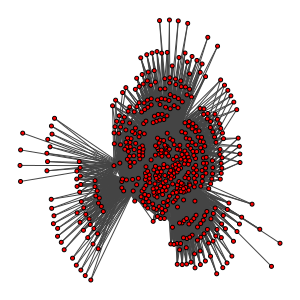

In [101]:
layout = graph.layout("fr")
plot(graph, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

In [109]:
clusters = list(graph.community_fastgreedy().as_clustering())

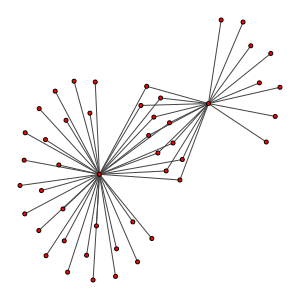

In [121]:
c = clusters[0]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

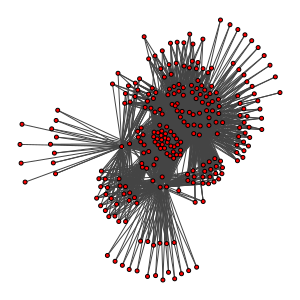

In [122]:
c = clusters[1]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

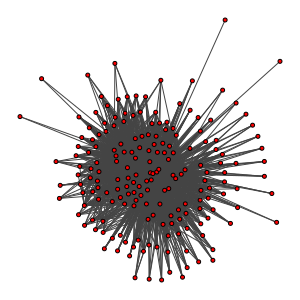

In [123]:
c = clusters[2]
sgr = graph.subgraph(c)
layout = sgr.layout("fr")
plot(sgr, layout=layout, bbox = (300, 300), margin=20, vertex_size=4, edge_width=1)

## sources

In [12]:
sources = read_table("sources")

Station - Станция дислокации (стоянки или освобождения после заказа)
Date - День, начиная с которого вагоны доступны (отсчет с дня запуска расчета)
Units - Количество вагонов, в  день дислокации
Stand - Формула расчета простоя (руб за сутки простоя на станции дислокации 1 вагона)
WagonModel - Модель вагонов


In [23]:
sources.to_csv("../data/sources.csv.gz")

## standplaces

In [13]:
standplaces = read_table("standplaces")

Station - Код станции отстоя
PricePut - Стоимость отстоя, руб за факт входа без расчета суток
PriceStand - Цена простоя в сутки


In [24]:
standplaces.to_csv("../data/standplaces.csv.gz")

## Metrics

In [14]:
metrics = read_table("Metrics")

From - Узел старта
To - Узел финиша
Group - Группа пробега
Distance - Расстояние пробега, км
Time - Время пробега, сутки
PriceUnit - Стоимость пробега, руб


In [25]:
metrics.to_csv("../data/metrics.csv.gz")

In [15]:
metrics.head()

,From,To,Group,Distance,Time,PriceUnit
1,10002,10303,100,9,5,104
2,10002,10303,200,9,5,138
3,10002,10303,305,9,5,355
4,10002,10905,100,60,5,685
5,10002,10905,200,60,5,914


# Targets
what is expected as a result

In [16]:
df2 = pd.read_excel("../data/output_wagon.xlsx", sheet_name=None)

In [27]:
list(df2)

['KPI', 'Orders', 'emptyMoves']

In [29]:
df2["KPI"]  # надо понять, какие из них желтые без ms excel

,"Расчет за 7 месяц (включая заявки которые ""выехали"" в 7 месяце)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,приоритет,1.0,2.0,3.0,4.0,всего
1,всего заказов,NaN,NaN,NaN,NaN,NaN
2,Выполненных заказов в кол-ве,NaN,NaN,NaN,NaN,NaN
3,Выполненных заказов в вагонах,NaN,NaN,NaN,NaN,NaN
4,% выполнения,NaN,NaN,NaN,NaN,NaN
5,Средняя премия,NaN,NaN,NaN,NaN,NaN
6,Суммарная премия,NaN,NaN,NaN,NaN,NaN
7,Кол-во порожних пробегов,NaN,NaN,NaN,NaN,NaN
8,Суммарная стоимость порожних пробегов,NaN,NaN,NaN,NaN,NaN
9,Кол-во вагново отправленных на станции отстоя,NaN,NaN,NaN,NaN,NaN


In [30]:
df2["Orders"]

,Код заказа,Станция старта,Станция финиша,Расчетная дата старта,Плановая дата старта,Время в пути,Мин допустимый объем,Запрошенный объем,Тарифы,Запрошенный тип вагона,Приоритет,Примененный тариф
0,OrderNum,Start,Finish,StartDate,StartDatePlan,Dur,MinUnit,MaxUnit,Tariffs,NeedWagonModel,ShortagePenalty,Tariff used
1,310225_836697942105_0804,946801,942105,0,NaN,14,1,1,10395:9215:8035:6855,2025,4,NaN


In [31]:
df2["emptyMoves"]

,Отправление,Прибытие,Тип простоя,Модель вагона,День отправления (от начала расчета),День прибытия (от начала расчета),Количество,Цена порожнего пробега (за вагон),Код следующего заказа,Расчитанный тариф следующего заказа
0,801301,801208,P,2052,20,25,1,383,304382_817369883809_0731(1),NaN
